In [1]:
from simu_PSF_polar import *
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import os
plt.rcParams['figure.figsize'] = [5,3]

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using GPU")
else:   
    device = torch.device('cpu')
    print("Using CPU")

Using GPU


In [3]:
def limit(x, lim, slope, upper=True):
    '''
    if upper:
       return torch.sum(torch.tensor(1/(1+torch.exp(-slope*(x-lim))), requires_grad=True, device=device))
    else:
        return torch.sum(torch.tensor(1/(1+torch.exp(slope*(x-lim))), requires_grad=True, device=device))
    '''
    if upper:
        return torch.sum(torch.exp((x-lim)*slope))
    else:
        return torch.sum(torch.exp(-1*(x-lim)*slope))
        

In [4]:
N_photons= torch.tensor(5000., device=device)
N=torch.tensor(80, device=device)
l_pixel=torch.tensor(16, device=device)
NA=torch.tensor(1.4, device=device)
mag=torch.tensor(100, device=device)
lambd=torch.tensor(617, device=device)
f_tube=torch.tensor(200, device=device)
MAG=torch.tensor(200/150, device=device)

In [5]:
xp = torch.tensor([0. for k in range(100)], device=device)
yp = torch.tensor([0. for k in range(100)], device=device)
z = torch.tensor((1.+np.random.rand(100))*0.8, device=device) #position of dipole in lambda units
d_ = torch.tensor([-1.5 for k in range(100)], device=device) #defocus of dipole in lambda units 4.4
rho = torch.tensor(10.+160.*np.random.rand(100), requires_grad=True, device=device)
eta = torch.tensor(30.+150.*np.random.rand(100), requires_grad=True, device=device)# 70
delta = torch.tensor(70.+80.*np.random.rand(100), requires_grad=True, device=device)#50

In [6]:
x, y, th1, phi, [Ex0, Ex1, Ex2], [Ey0, Ey1, Ey2], r, r_cut, k, f_o = vectorial_BFP_perfect_focus(N, NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, device=device)

In [7]:
second_plane = torch.tensor([0.35, 0, -0.35], device=device)
polar_projections = torch.tensor([0., 45., 0.], device=device)

In [8]:
u, v, M = compute_M(xp=xp, yp=yp, zp=z, d=d_, x=x, y=y, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k, f_o=f_o, second_plane=second_plane, polar_projections=polar_projections, N=N, l_pixel=l_pixel, NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG,
                   device=device, aberrations=False, defocus_coef=1e-5, spherical_coef=-1.5)

c:\Users\utilisateur\miniforge3\envs\deeplearning_env\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
psf = PSF(rho=rho, eta=eta, delta=delta, M=M, N_photons=N_photons)

z =  1.536377014422418


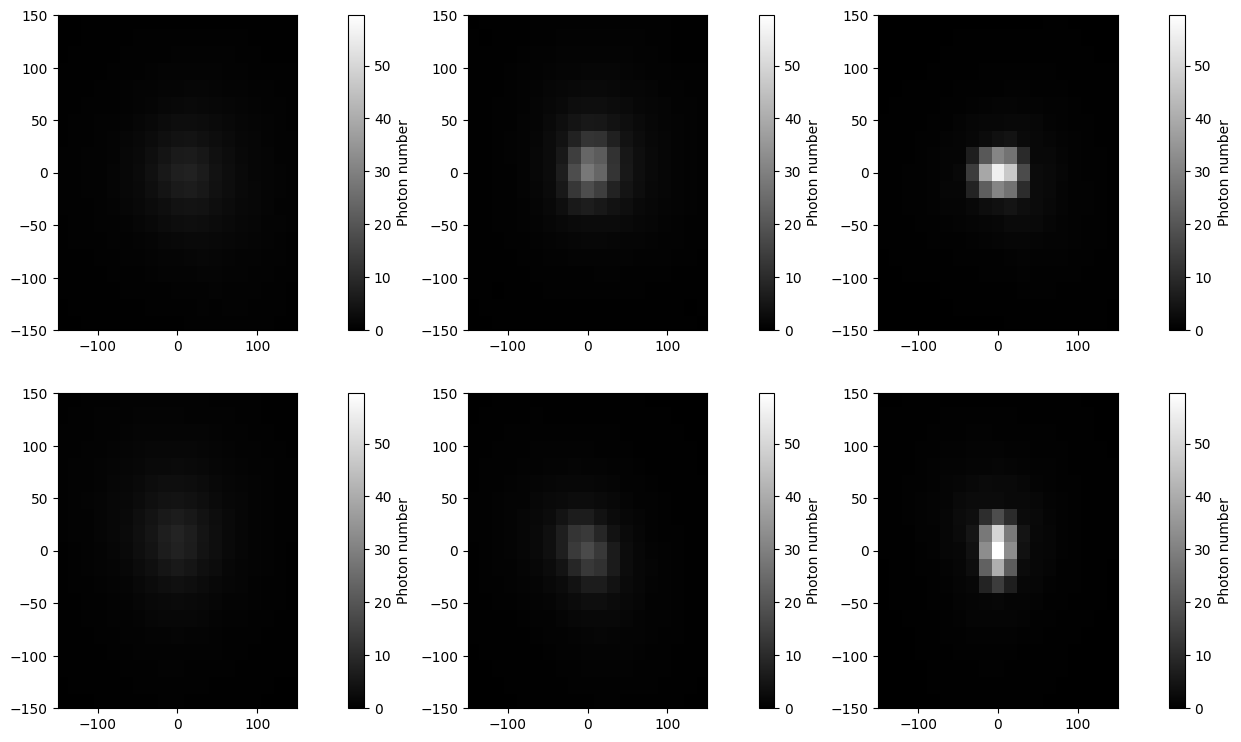

In [10]:
nn = 12
print('z = ', z[nn].cpu().detach().numpy())

vmax=torch.max(psf[nn]).cpu().detach().numpy()
vmin=torch.min(psf[nn]).cpu().detach().numpy()

plt.rcParams['figure.figsize'] = [15,9]
fig, ax = plt.subplots(2,3)
mesh1 = ax[0,0].pcolormesh(u.cpu(), v.cpu(), psf[nn,0,0].cpu().detach().numpy(), cmap='gray', vmin=vmin, vmax=vmax)
mesh2 = ax[1,0].pcolormesh(u.cpu(), v.cpu(), psf[nn,0,1].cpu().detach().numpy(), cmap='gray', vmin=vmin, vmax=vmax)
mesh3 = ax[0,1].pcolormesh(u.cpu(), v.cpu(), psf[nn,1,0].cpu().detach().numpy(), cmap='gray', vmin=vmin, vmax=vmax)
mesh4 = ax[1,1].pcolormesh(u.cpu(), v.cpu(), psf[nn,1,1].cpu().detach().numpy(), cmap='gray', vmin=vmin, vmax=vmax)
mesh5 = ax[0,2].pcolormesh(u.cpu(), v.cpu(), psf[nn,2,0].cpu().detach().numpy(), cmap='gray', vmin=vmin, vmax=vmax)
mesh6 = ax[1,2].pcolormesh(u.cpu(), v.cpu(), psf[nn,2,1].cpu().detach().numpy(), cmap='gray', vmin=vmin, vmax=vmax)
ax[0,0].set_xlim((-150,150))
ax[0,0].set_ylim((-150,150))
cb = plt.colorbar(mesh1, pad=0.15, label='Photon number')
ax[0,1].set_xlim((-150,150))
ax[0,1].set_ylim((-150,150))
cb = plt.colorbar(mesh2, pad=0.15, label='Photon number')
ax[1,0].set_xlim((-150,150))
ax[1,0].set_ylim((-150,150))
cb = plt.colorbar(mesh3, pad=0.15, label='Photon number')
ax[1,1].set_xlim((-150,150))
ax[1,1].set_ylim((-150,150))
cb = plt.colorbar(mesh4, pad=0.15, label='Photon number')
ax[0,2].set_xlim((-150,150))
ax[0,2].set_ylim((-150,150))
cb = plt.colorbar(mesh5, pad=0.15, label='Photon number')
ax[1,2].set_xlim((-150,150))
ax[1,2].set_ylim((-150,150))
cb = plt.colorbar(mesh6, pad=0.15, label='Photon number')

In [11]:
def signal(psf):
    return torch.mean(torch.max(torch.flatten(psf, start_dim=1), dim=1)[0])

In [12]:
def general_loss(M, rho, eta, delta, N_photons, data):
    h = PSF(rho=rho, eta=eta, delta=delta, M=M, N_photons=N_photons)
    #
    # loss = torch.sum(torch.add(h, -data).pow(2))
    loss = torch.sum(torch.add(h, -(data+sig_r**2)*torch.log(h+B+sig_r**2)))
    #rho_bound = limit(rho, 180, 100, upper=True) + limit(rho, 0, 100, upper=False)
    delta_bound = limit(delta, 180, 100, upper=True) + limit(delta, 1, 100, upper=False)
    #eta_bound = limit(eta, 180, 100, upper=True) + limit(eta, 0, 100, upper=False)
    return loss + 1000.*(delta_bound) #+ 0.1*torch.sum(h.pow(2))

In [13]:
background = 11.
sig_b = 6.
read=1.5
bias=11.
psf_n = noise(psf, QE=1, EM=1, b=background, sigma_b=sig_b, sigma_r=read, bias=bias)

z =  1.536377014422418


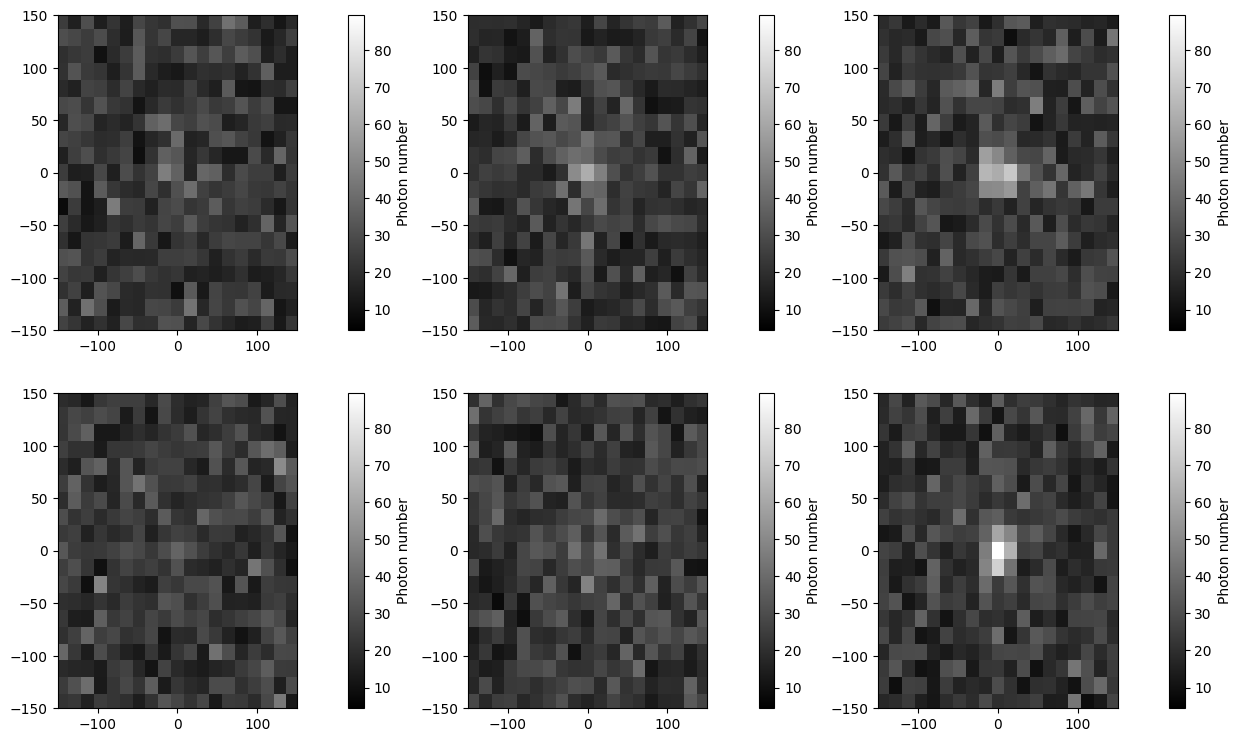

In [14]:
print('z = ', z[nn].cpu().detach().numpy())

vmax=torch.max(psf_n[nn]).cpu().detach().numpy()
vmin=torch.min(psf_n[nn]).cpu().detach().numpy()

plt.rcParams['figure.figsize'] = [15,9]
fig, ax = plt.subplots(2,3)
mesh1 = ax[0,0].pcolormesh(u.cpu(), v.cpu(), psf_n[nn,0,0].cpu().detach().numpy(), cmap='gray', vmin=vmin, vmax=vmax)
mesh2 = ax[1,0].pcolormesh(u.cpu(), v.cpu(), psf_n[nn,0,1].cpu().detach().numpy(), cmap='gray', vmin=vmin, vmax=vmax)
mesh3 = ax[0,1].pcolormesh(u.cpu(), v.cpu(), psf_n[nn,1,0].cpu().detach().numpy(), cmap='gray', vmin=vmin, vmax=vmax)
mesh4 = ax[1,1].pcolormesh(u.cpu(), v.cpu(), psf_n[nn,1,1].cpu().detach().numpy(), cmap='gray', vmin=vmin, vmax=vmax)
mesh5 = ax[0,2].pcolormesh(u.cpu(), v.cpu(), psf_n[nn,2,0].cpu().detach().numpy(), cmap='gray', vmin=vmin, vmax=vmax)
mesh6 = ax[1,2].pcolormesh(u.cpu(), v.cpu(), psf_n[nn,2,1].cpu().detach().numpy(), cmap='gray', vmin=vmin, vmax=vmax)
ax[0,0].set_xlim((-150,150))
ax[0,0].set_ylim((-150,150))
cb = plt.colorbar(mesh1, pad=0.15, label='Photon number')
ax[0,1].set_xlim((-150,150))
ax[0,1].set_ylim((-150,150))
cb = plt.colorbar(mesh2, pad=0.15, label='Photon number')
ax[1,0].set_xlim((-150,150))
ax[1,0].set_ylim((-150,150))
cb = plt.colorbar(mesh3, pad=0.15, label='Photon number')
ax[1,1].set_xlim((-150,150))
ax[1,1].set_ylim((-150,150))
cb = plt.colorbar(mesh4, pad=0.15, label='Photon number')
ax[0,2].set_xlim((-150,150))
ax[0,2].set_ylim((-150,150))
cb = plt.colorbar(mesh5, pad=0.15, label='Photon number')
ax[1,2].set_xlim((-150,150))
ax[1,2].set_ylim((-150,150))
cb = plt.colorbar(mesh6, pad=0.15, label='Photon number')

In [15]:
sig_x = 0.15
x_error = xp+torch.tensor(normal(0, sig_x, xp.cpu().detach().numpy().shape), device=device)
y_error = yp+torch.tensor(normal(0, sig_x, yp.cpu().detach().numpy().shape), device=device)

In [16]:
u, v, M = compute_M(xp=x_error, yp=y_error, zp=z, d=d_, x=x, y=y, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k, f_o=f_o, second_plane=second_plane, polar_projections=polar_projections, N=N, l_pixel=l_pixel, NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG,
                   device=device, aberrations=False, defocus_coef=1e-5, spherical_coef=-1.5)

In [32]:
sigma_xy = np.linspace(0., 0.3, 100)

In [ ]:
for sig_x in sigma_xy:
    x_error = xp+torch.tensor(normal(0, sig_x, xp.cpu().detach().numpy().shape), device=device)
    y_error = yp+torch.tensor(normal(0, sig_x, yp.cpu().detach().numpy().shape), device=device)

    u, v, M = compute_M(xp=x_error, yp=y_error, zp=z, d=d_, x=x, y=y, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                        , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k, f_o=f_o, second_plane=second_plane, polar_projections=polar_projections, N=N, l_pixel=l_pixel, NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG,
                    device=device, aberrations=False, defocus_coef=1e-5, spherical_coef=-1.5)

    B = background + bias
    sig_r = np.sqrt(read**2 + sig_b**2)

    params = torch.tensor(np.concatenate((rho.cpu().clone().detach()+40.*(np.random.rand(100)-0.5), #rho
                                        np.array([90. for i in range(100)]), #eta
                                        delta.cpu().clone().detach()+40.*(np.random.rand(100)-0.5))),
                                        requires_grad=True, device=device)

    # Use Stochastic Gradient Descent (SGD) to optimize params
    optimizer = torch.optim.Adam([params], lr=0.9)  # Learning rate = 0.01

    num_epochs_max = 300
    loss_ = []
    rho_ = []
    eta_ = []
    delta_ = []
    N_p = []

    for i in tqdm(range(num_epochs_max)):
        optimizer.zero_grad()  # Reset gradients
        #print(params[0:3], params[3:6], params[6:])
        loss = general_loss(M.detach(), params[0:100], params[100:200], params[200:], N_photons.detach(), psf_n.detach())
        #loss = general_loss(M.detach(), params[0], params[1], params[2], N_photons.detach(), psf.detach())
        loss_.append(loss.cpu().detach().numpy())

        rho___ = params[0:100].cpu().clone().detach().numpy()%180
        rho___[rho___-rho.cpu().clone().detach().numpy() > 90] = rho___[rho___-rho.cpu().clone().detach().numpy() > 90] - 180.
        rho___[rho___-rho.cpu().clone().detach().numpy() < -90] = rho___[rho___-rho.cpu().clone().detach().numpy() < -90] + 180.
        eta___ = params[100:200].cpu().clone().detach().numpy()%180
        eta___[eta___-eta.cpu().clone().detach().numpy() > 90] = eta___[eta___-eta.cpu().clone().detach().numpy() > 90] - 180.
        eta___[eta___-eta.cpu().clone().detach().numpy() < -90] = eta___[eta___-eta.cpu().clone().detach().numpy() < -90] + 180.
        rho_.append(rho___)
        eta_.append(eta___)
        delta_.append(params[200:].cpu().clone().detach().numpy())

        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters
    signal_ = signal(psf.cpu().detach())
    #np.savez_compressed('D:/AMAURY/data_simu/stage/2025_07_25_error_on_xy/'+str(sig_x)+'.npz', signal=signal_.detach().numpy(), std=sig_r, floor=B, rho=np.array(rho_-rho.cpu().clone().detach().numpy())[-1,:], eta=np.array(eta_-eta.cpu().clone().detach().numpy())[-1,:], delta=np.array(delta_-delta.cpu().clone().detach().numpy())[-1,:])

C:\Users\utilisateur\AppData\Local\Temp\ipykernel_30312\2529101270.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  params = torch.tensor(np.concatenate((rho.cpu().clone().detach()+40.*(np.random.rand(100)-0.5), #rho
C:\Users\utilisateur\AppData\Local\Temp\ipykernel_30312\2529101270.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  delta.cpu().clone().detach()+40.*(np.random.rand(100)-0.5))),
100%|██████████| 300/300 [03:36<00:00,  1.39it/s]
C:\Users\utilisateur\AppData\Local\Temp\ipykernel_30312\2529101270.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  params = torch.tensor(np.concatenate((rho.cpu().clone().detach()+40.*(np.random.rand(100)-0.5), #rho
C:\Users\utilisateur\AppData\Local\Temp\ipykernel_

In [ ]:
folder = 'D:/AMAURY/data_simu/stage/2025_07_25_error_on_xy'
rhos = []
etas = []
deltas = []
floors = []
stds = []
signals = []
for file in os.listdir(folder):
    data = np.load(folder+'/'+file)
    rhos.append(data['rho'])
    etas.append(data['eta'])
    deltas.append(data['delta'])
    stds.append(data['std'])
    signals.append(data['signal'])
    floors.append(data['floor'])


In [21]:
rhos = np.array(rhos)
etas = np.array(etas)
deltas = np.array(deltas)

Text(0, 0.5, '$| \\delta - \\delta{\\mathrm{TRUE}}|$ $(^{\\circ})$')

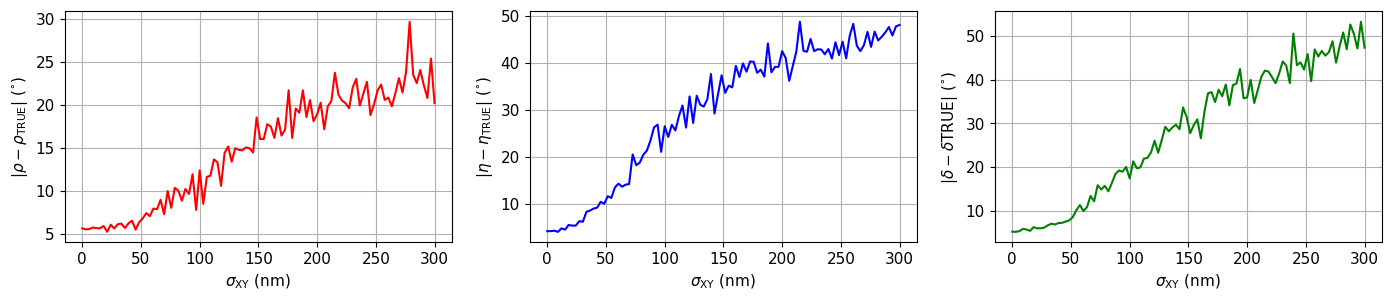

In [59]:
fig, ax = plt.subplots(1,3)
plt.rcParams.update({'font.size': 11})
plt.rcParams['figure.figsize'] = [17,3.]

ax[0].plot(sigma_xy*1000, np.mean(np.sqrt(rhos**2), axis=1), c='r')
ax[0].grid()
ax[0].set_xlabel('$\\sigma_{\\mathrm{XY}}$ (nm)')
ax[0].set_ylabel('$ |\\rho - \\rho_{\\mathrm{TRUE}}|$ $(^{\\circ})$')

ax[1].plot(sigma_xy*1000, np.mean(np.sqrt(etas**2), axis=1), c='b')
ax[1].grid()
ax[1].set_xlabel('$\\sigma_{\\mathrm{XY}}$ (nm)')
ax[1].set_ylabel('$| \\eta - \\eta_{\\mathrm{TRUE}}|$ $(^{\\circ})$')

ax[2].plot(sigma_xy*1000, np.mean(np.sqrt(deltas**2), axis=1), c='g')
ax[2].grid()
ax[2].set_xlabel('$\\sigma_{\\mathrm{XY}}$ (nm)')
ax[2].set_ylabel('$| \\delta - \\delta{\\mathrm{TRUE}}|$ $(^{\\circ})$')